In [24]:
import os
import sys
import numpy as np
import pandas as pd
from numpy import random as npr
import time
import torch

from plotly import graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [25]:
SEED = 2021
BOOKS_DATASET_PATH = r"/../../data/books_dataset.csv"
REAL_DATASET_SAMPLE_SIZE = 0.05
CACHE_DIR = "./cache"
SYNTHETIC_USERS_COUNT = 100
SYNTHETIC_ITEMS_COUNT = 100
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20
CTGAN_EPOCHS = 10

npr.seed(SEED)

### Visualization functions

In [27]:
import importlib
sys.path.insert(0, r'../utilits/')

from tools import *

# 1. Load and prepare data

In [3]:
real_dataset = pd.read_csv(module_path + BOOKS_DATASET_PATH)
real_dataset = real_dataset[real_dataset.book_rating != 0]
npr.seed(SEED)
real_dataset = real_dataset.sample(frac=REAL_DATASET_SAMPLE_SIZE)

real_dataset = real_dataset.drop(["Location", "rating_sum", "Book_Title", "Count_All_Rate", "Country", "Book_Author", "Publisher"], axis=1)
real_dataset["ISBN"] = real_dataset["ISBN"].astype('category').cat.codes
real_dataset.shape

(19192, 6)

In [4]:
df_deepfm = pd.read_csv(module_path + BOOKS_DATASET_PATH)
df_deepfm = df_deepfm[df_deepfm.book_rating != 0]

df_deepfm = df_deepfm.drop(["Location", "rating_sum", "Book_Title", "Count_All_Rate", "Country", "Book_Author", "Publisher"], axis=1)
df_deepfm["ISBN"] = df_deepfm["ISBN"].astype('category').cat.codes
df_deepfm.shape

(383842, 6)

In [5]:
df_deepfm = df_deepfm.reset_index(drop=True)
real_dataset = real_dataset.reset_index(drop=True)

In [6]:
users_df = real_dataset[['user_id', 'Age']]
books_df = real_dataset[['ISBN', 'rating_Avg', 'Year_Of_Publication']]

users_df = users_df.drop_duplicates()
books_df = books_df.drop_duplicates()

# 2. Load synthetic data and train DeepFM components

In [ ]:
syn_users_generator = CTGAN.load(r'./books_models/CTGAN_users.pkl')
syn_books_generator = GaussianCopula.load(r'./books_models/GaussianCopula_books.pkl')

In [10]:
npr.seed(SEED)
with torch.cuda.device(1):
    syn_users_df = syn_users_generator.sample(100)

In [11]:
npr.seed(SEED)
with torch.cuda.device(1):
    syn_books_df = syn_books_generator.sample(100)

In [12]:
syn_users_df["userID"] = range(len(syn_users_df))
syn_books_df["bookID"] = range(len(syn_books_df))

In [13]:
df_deepfm_con = pd.concat([df_deepfm, real_dataset])

In [14]:
df_deepfm_con = df_deepfm_con.drop_duplicates()
df_deepfm_con.shape

(403034, 6)

In [15]:
deepfm_input = real_dataset.copy()
deepfm_input_big = df_deepfm_con.copy()

In [16]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models import deepnets
from deeptables.datasets import dsutils
from tensorflow import keras
from deeptables.models import deeptable
from sklearn.model_selection import train_test_split

In [17]:
npr.seed(SEED)
y = deepfm_input["book_rating"]
X = deepfm_input.drop(["book_rating", "user_id", "ISBN"], axis=1)
y_big = deepfm_input_big["book_rating"]
X_big = deepfm_input_big.drop(["book_rating", "user_id", "ISBN"], axis=1)
x_train, x_tests, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train_big, x_tests_big, y_train_big, y_test_big = train_test_split(X_big, y_big, test_size=0.2, random_state=42)

test_results = []
net = deepnets.DeepFM
conf = ModelConfig(
    nets=net, 
    optimizer=keras.optimizers.RMSprop(),
    auto_discrete=True,
    earlystopping_patience=50,
)

In [18]:
dt = deeptable.DeepTable(config=conf)
start = time.time()
model, history = dt.fit(x_train_big, y_train_big, epochs=50, batch_size=64)
end = time.time()
print('Training of DeepFM')
print(end - start)

06-29 12:58:39 I deeptables.m.deeptable.py 335 - X.Shape=(322427, 3), y.Shape=(322427,), batch_size=64, config=ModelConfig(name='conf-1', nets=['linear', 'fm_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer=<keras.optimizer_v2.rmsprop.RMSprop object at 0x7fba8862fc18>, loss='auto', dnn_params={'hidden_units': ((128, 0, False), (64, 0, False)), 'activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_ra

06-29 12:58:41 W hypernets.t.cache.py 185 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/hypernets/tabular/cache.py", line 152, in _cache_call
    cache_key = hash_data(key_items)
  File "/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/hypernets/utils/common.py", line 231, in hash_data
    data = {hash_data(k): hash_data(v) if v is not None else v for k, v in data.items()}
  File "/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/hypernets/utils/common.py", line 231, in <dictcomp>
    data = {hash_data(k): hash_data(v) if v is not None else v for k, v in data.items()}
  File "/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/hypernets/utils/common.py", line 229, in hash_data
    data = [hash_data(x) if x is not None else x for x in data]
  File "/data/home/agurov/.conda/envs/

06-29 12:58:41 I hypernets.u.common.py 164 - 10 class detected, inferred as a [multiclass classification] task
06-29 12:58:41 I deeptables.m.preprocessor.py 258 - Preparing features...
06-29 12:58:41 I deeptables.m.preprocessor.py 333 - Preparing features taken 0.009412527084350586s
06-29 12:58:41 I deeptables.m.preprocessor.py 338 - Data imputation...
06-29 12:58:41 I deeptables.m.preprocessor.py 380 - Imputation taken 0.02718973159790039s
06-29 12:58:41 I deeptables.m.preprocessor.py 385 - Categorical encoding...
06-29 12:58:41 I deeptables.m.preprocessor.py 390 - Categorical encoding taken 0.0003573894500732422s
06-29 12:58:41 I deeptables.m.preprocessor.py 395 - Data discretization...
06-29 12:58:41 I hypernets.t.sklearn_ex.py 558 - 3 variables to discrete.
06-29 12:58:41 I deeptables.m.preprocessor.py 401 - Discretization taken 0.07413578033447266s
06-29 12:58:41 I deeptables.m.preprocessor.py 193 - fit_transform taken 0.15162396430969238s
06-29 12:58:41 I deeptables.m.deeptable.p

/data/home/agurov/.conda/envs/py3.6-Sber/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [41]:
score = dt.evaluate(X, y, batch_size=64, verbose=0)
score

06-29 12:45:26 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 12:45:26 I deeptables.m.preprocessor.py 246 - transform_X taken 0.013312816619873047s
06-29 12:45:26 I deeptables.m.preprocessor.py 227 - Transform [y]...
06-29 12:45:26 I deeptables.m.preprocessor.py 233 - transform_y taken 0.0011856555938720703s
06-29 12:45:26 I deeptables.m.deepmodel.py 169 - Performing evaluation...


{'loss': 1.845219373703003, 'accuracy': 0.24609212577342987}

In [42]:
mae = abs(dt.predict(X) - y).mean()
mae

06-29 12:45:29 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 12:45:29 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 12:45:29 I deeptables.m.preprocessor.py 246 - transform_X taken 0.011408329010009766s
06-29 12:45:29 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 12:45:29 I deeptables.m.deeptable.py 540 - predict_proba taken 0.4199507236480713s
06-29 12:45:29 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


1.406731971654856

In [43]:
check = dt.predict(x_tests)
dct_c = {}
for i in check:
    if i in dct_c:
        dct_c[i] += 1
    else:
        dct_c[i] = 0
dct_c

06-29 12:45:32 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 12:45:32 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 12:45:32 I deeptables.m.preprocessor.py 246 - transform_X taken 0.010316848754882812s
06-29 12:45:32 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 12:45:32 I deeptables.m.deeptable.py 540 - predict_proba taken 0.10744214057922363s
06-29 12:45:32 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


{8: 3223, 10: 450, 5: 40, 7: 122}

In [44]:
syn_users_df["_merge_key"] = syn_books_df["_merge_key"] = 1
syn_merged_df = pd.merge(syn_users_df, syn_books_df, on="_merge_key")
syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)

deepfm_syn_input = syn_merged_df.copy()

### Create dense syn data

In [45]:
df_resp = deepfm_syn_input.copy()

In [46]:
npr.seed(SEED)
resp = dt.predict(df_resp.drop(["userID", "bookID"], axis=1))

df_resp['rating'] = resp

06-29 12:45:36 I deeptables.m.deeptable.py 661 - Perform prediction...
06-29 12:45:36 I deeptables.m.preprocessor.py 239 - Transform [X]...
06-29 12:45:36 I deeptables.m.preprocessor.py 246 - transform_X taken 0.010039329528808594s
06-29 12:45:36 I deeptables.m.deepmodel.py 142 - Performing predictions...
06-29 12:45:37 I deeptables.m.deeptable.py 540 - predict_proba taken 0.4185912609100342s
06-29 12:45:37 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


In [47]:
dct = {}
for i in resp:
    if i in dct:
        dct[i] += 1
    else:
        dct[i] = 0
dct

{8: 8420, 10: 1099, 7: 291, 5: 186}

In [48]:
matrix = pd.DataFrame()
matrix["rating"] = df_resp['rating']
matrix["user_id"] = df_resp["userID"].astype("category").cat.codes
matrix["item_id"] = df_resp["bookID"].astype("category").cat.codes

In [49]:
mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
mt.rating.value_counts()

8     8421
10    1100
7      292
5      187
Name: rating, dtype: int64

In [50]:
mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
mtp

item_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
0,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
1,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
2,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
3,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
4,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
96,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8
97,8,8,8,8,8,8,8,10,8,8,...,8,8,10,8,8,8,8,8,8,8


### Create matrix of average ratings

In [51]:
sim_matrix = np.zeros([100, 100])
for u in range(100):
    for i in range(100):
        if mtp.iloc[u, i] != 0:
            sim_matrix[u, i] = round(syn_books_df.iloc[i, 0])
            if sim_matrix[u, i] > 10:
                sim_matrix[u, i] = 10
        else:
            sim_matrix[u, i] = 0
sim_matrix

array([[3., 4., 2., ..., 5., 2., 4.],
       [3., 4., 2., ..., 5., 2., 4.],
       [3., 4., 2., ..., 5., 2., 4.],
       ...,
       [3., 4., 2., ..., 5., 2., 4.],
       [3., 4., 2., ..., 5., 2., 4.],
       [3., 4., 2., ..., 5., 2., 4.]])

# Experiment

In [53]:
import importlib
sys.path.insert(0, r'../modules/')

import evaluator, trainers, utils, models
importlib.reload(models)
importlib.reload(trainers)
importlib.reload(evaluator)
importlib.reload(utils)

<module 'utils' from '../modules/utils.py'>

DeepCTR-PyTorch version 0.2.8 detected. Your version is 0.2.7.
Use `pip install -U deepctr-torch` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR-Torch/releases/tag/v0.2.8


In [54]:
class ResponseFunction:
    def __init__(self, heu_matrix, nn_matrix, noise_matrix):
        assert heu_matrix.shape == nn_matrix.shape
        self._heu_matrix = heu_matrix
        self._nn_matrix = nn_matrix
        self._noise_matrix = noise_matrix
        
    def __call__(self, a1: float, a2: float):
        a3 = max(0.0, 1 - a1 - a2)
        
        return (
            a1 * self._heu_matrix
            + a2 * self._nn_matrix 
            + a3 * self._noise_matrix #np.random.randint(0, 11, size = self._heu_matrix.shape)
            #to avoid identical zeros in NMF
            + 0.00001
        )

# Real-Syn Comparison

## Real Data

In [23]:
real_sample = deepfm_input.sample(n=100)[['user_id', 'ISBN', 'book_rating']]

In [24]:
print('Users: ', len(real_sample.user_id.unique()))
print('Items: ', len(real_sample.ISBN.unique()))
print('Pairs: ', 100)

print('Dense: ', 100/(len(real_sample.user_id.unique()) * len(real_sample.ISBN.unique())))

Users:  96
Items:  100
Pairs:  100
Dense:  0.010416666666666666


In [26]:
real_results = pd.DataFrame()

for num in range(1, 11):
    real_sample = deepfm_input.sample(n=100)[['user_id', 'ISBN', 'book_rating']]
    matrix = pd.DataFrame()
    matrix["user_id"] = real_sample["user_id"].astype("category").cat.codes
    matrix["item_id"] = real_sample["ISBN"].astype("category").cat.codes
    matrix["rating"] = real_sample["book_rating"]
    
    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
    
    _resp_fn_config = evaluator.ResponseFunctionConfig(
    factory=ResponseFunction,
    args=[mtp, mtp, mtp]
    )
    
    _evaluators = [
    
    evaluator.TrainTestExecutorConfig(
        factory=trainers.NmfTrainTestExecutor,
        args={},
        model_name="nmf"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.SvdTrainTestExecutor,
        args={},
        model_name="svd"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.KnnTrainTestExecutor,
        args={},
        model_name="knn"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.AutoRecTrainTestExecutor,
        args={},
        model_name="autorec"
    ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)
    
    with torch.cuda.device(1):
        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )
    
    real_results = real_results.append(results)

Subprocess started.Subprocess started.Subprocess started.


RMSE: 3.5355RMSE: 3.5355RMSE: 3.5355


MAE:  3.5000MAE:  3.5000MAE:  3.5000


RMSE: 1.7341RMSE: 1.7341

RMSE: 1.7341MAE:  1.5278MAE:  1.5278


MAE:  1.5278
RMSE: 1.7002RMSE: 1.7002

RMSE: 1.7002MAE:  1.4000MAE:  1.4000


MAE:  1.4000
RMSE: 2.1221RMSE: 2.1221

MAE:  1.9213RMSE: 2.1221MAE:  1.9213


MAE:  1.9213
RMSE: 1.7366
RMSE: 1.7366
MAE:  1.5000
MAE:  1.5000
RMSE: 2.0293
MAE:  1.6944
RMSE: 2.0293
MAE:  1.6944
RMSE: 3.3196
MAE:  2.5000
RMSE: 3.3196
MAE:  2.5000
RMSE: 2.1703
MAE:  1.4861
RMSE: 2.1703
MAE:  1.4861
RMSE: 2.5495
MAE:  2.5000
RMSE: 1.8934
MAE:  1.6944
RMSE: 1.9431
MAE:  1.7300
RMSE: 1.5508
MAE:  1.1914
Subprocess started.Subprocess started.Subprocess started.


RMSE: 3.5355RMSE: 3.5355

RMSE: 3.5355MAE:  3.5000MAE:  3.5000


MAE:  3.5000
RMSE: 2.2064
RMSE: 2.2064MAE:  1.8611

RMSE: 2.2064MAE:  1.8611

MAE:  1.8611
RMSE: 1.6248
RMSE: 1.6248MAE:  1.4000

RMSE: 1.6248MAE:  1.4000

MAE:  1.4000
RMSE: 2.0404
RMSE: 2.0

## Syn Data

In [29]:
syn_results = pd.DataFrame()

for num in range(1, 11):

    syn_books_df = syn_books_generator.sample(100)
    syn_users_df = syn_users_generator.sample(100)
    
    syn_users_df["_merge_key"] = syn_books_df["_merge_key"] = 1
    syn_merged_df = pd.merge(syn_users_df, syn_books_df, on="_merge_key")
    syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)

    deepfm_syn_input = syn_merged_df.copy()
    
    df_resp = deepfm_syn_input.sample(frac=0.010413412475268145)
    df_resp_no = deepfm_syn_input.drop(df_resp.index)
    
    
    npr.seed(SEED)
    resp = dt.predict(df_resp.drop(["userID", "bookID"], axis=1))
    df_resp['rating'] = resp
    df_resp_no['rating'] = np.asarray([np.nan for i in range(df_resp_no.shape[0])])
    df_full = pd.concat([df_resp, df_resp_no])

    
    matrix = pd.DataFrame()
    matrix["rating"] = df_full['rating']
    matrix["user_id"] = df_full["userID"].astype("category").cat.codes
    matrix["item_id"] = df_full["bookID"].astype("category").cat.codes
    
    
    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
    
    _resp_fn_config = evaluator.ResponseFunctionConfig(
    factory=ResponseFunction,
    args=[mtp, mtp, mtp]
    )
    
    _evaluators = [
    
    evaluator.TrainTestExecutorConfig(
        factory=trainers.NmfTrainTestExecutor,
        args={},
        model_name="nmf"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.SvdTrainTestExecutor,
        args={},
        model_name="svd"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.KnnTrainTestExecutor,
        args={},
        model_name="knn"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.AutoRecTrainTestExecutor,
        args={},
        model_name="autorec"
    ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)
    
    with torch.cuda.device(1):
        results = _evaluator.evaluate(
            _evaluators, 
            a_sample_rate=2,
            test_size=0.2, 
            sample_sizes=[0.1, 0.3, 0.5, 0.9]
        )
    
    syn_results = syn_results.append(results)

Subprocess started.Subprocess started.Subprocess started.


RMSE: 2.5125RMSE: 2.5125RMSE: 2.5125

MAE:  2.5000
MAE:  2.5000

MAE:  2.5000
RMSE: 1.0426RMSE: 1.0426

MAE:  0.8393MAE:  0.8393

RMSE: 1.0426
MAE:  0.8393
RMSE: 1.5814RMSE: 1.5814

MAE:  1.1228MAE:  1.1228

RMSE: 1.5814
MAE:  1.1228
RMSE: 2.0159RMSE: 2.0159

MAE:  1.5536MAE:  1.5536

RMSE: 1.8028
MAE:  1.5000
RMSE: 2.0159
MAE:  1.5536
RMSE: 1.4746
MAE:  1.1964
RMSE: 1.8028
MAE:  1.5000
RMSE: 1.1761
MAE:  0.8404
RMSE: 1.4746
MAE:  1.1964
RMSE: 1.8897
MAE:  1.5307
RMSE: 1.1761
MAE:  0.8404
RMSE: 1.8897
MAE:  1.5307
RMSE: 1.8028
MAE:  1.5000
RMSE: 1.1717
MAE:  0.9107
RMSE: 0.8982
MAE:  0.6785
RMSE: 2.4999
MAE:  2.0056
Subprocess started.Subprocess started.Subprocess started.


RMSE: 2.5125
RMSE: 2.5125RMSE: 2.5125MAE:  2.5000


MAE:  2.5000MAE:  2.5000

RMSE: 1.5520
MAE:  1.3091RMSE: 1.5520RMSE: 1.5520


MAE:  1.3091
MAE:  1.3091
RMSE: 1.5219
MAE:  1.2266RMSE: 1.5219

MAE:  1.2266
RMSE: 1.5219
MAE:  1.2266
RMSE: 1.4124
MAE:  1.0

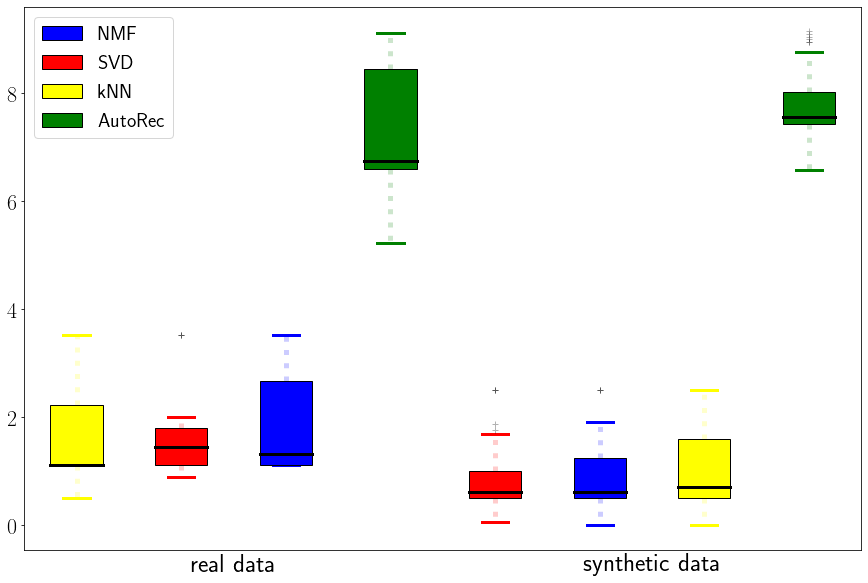

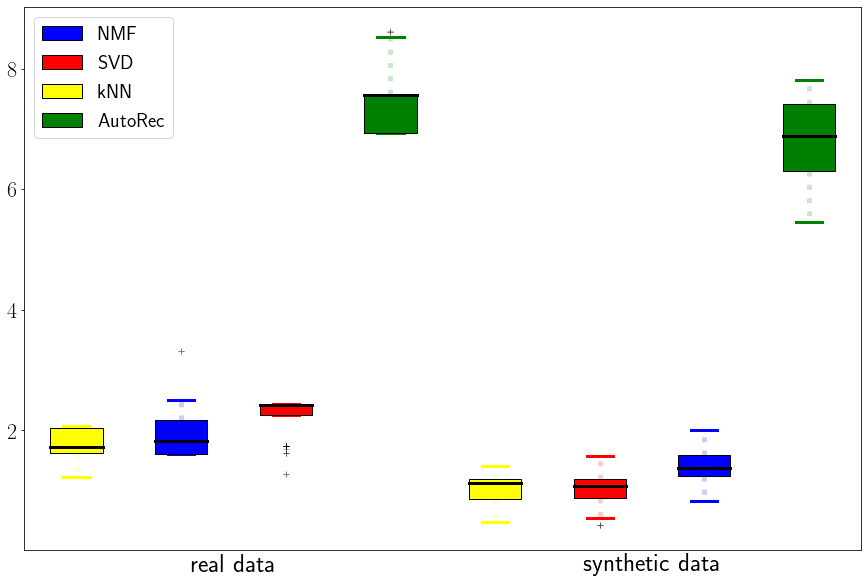

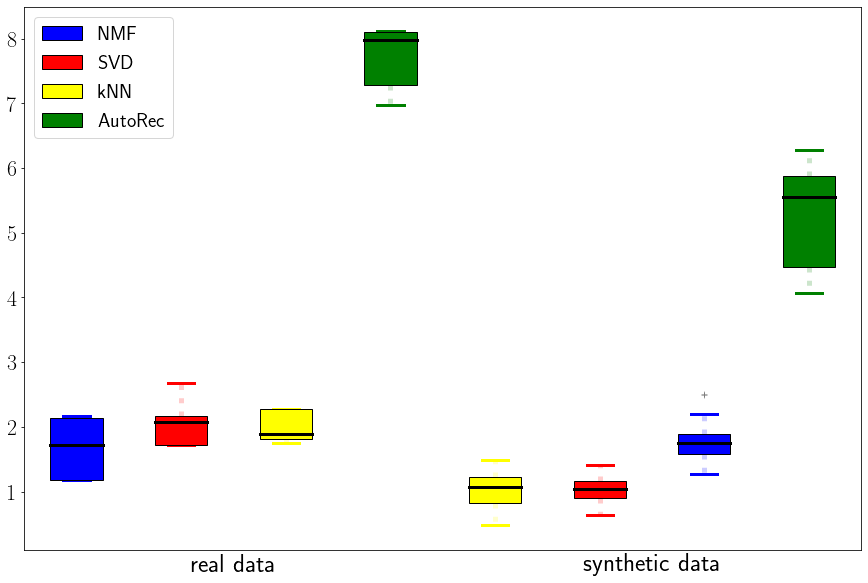

In [27]:
real = real_results
syn = syn_results

boxplot(real[real.sample_size==0.1], syn[syn.sample_size==0.1], legend_loc='upper left')

boxplot(real[real.sample_size==0.5], syn[syn.sample_size==0.5], legend_loc='upper left')

boxplot(real[real.sample_size==0.9], syn[syn.sample_size==0.9], legend_loc='upper left')